# Exploratory Data Analysis of Culinary DB

## In this jupyter notebook, we will be exploring the various data files of Culinary DB :)  

In [1]:
# importing necessary libraries 
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import warnings

## Data Preparation of Recipe Details CSV file

In [2]:
# Importing data 
df_recipe_name = pd.read_csv("../CulinaryDB/01_Recipe_Details.csv")

In [3]:
# Checking for nulls
df_recipe_name.isnull().values.any()

np.False_

#### Luckily, no nulls !

In [4]:
# grabbing recipe names
labels_recipe_names= list(df_recipe_name["Title"])

# grabbing different types of cuisines
labels_recipes_cuisines = list(df_recipe_name["Cuisine"])
label_unique_cuisines = list(set(labels_recipes_cuisines))

n_cuisines = len(label_unique_cuisines)

# mapping unique cuisines to corresponding numeric indices in the recipe labels
labels_recipes_cuisines_v = np.arange(len(labels_recipes_cuisines))
for ind in range(n_cuisines):
    matching_indices = np.asarray([index for index, element in enumerate(labels_recipes_cuisines) if element == label_unique_cuisines[ind]])
    labels_recipes_cuisines_v[matching_indices] = ind

labels_recipes_cuisines = labels_recipes_cuisines_v

## Data Preparation of Ingredient CSVs

In [5]:
# Importing data 
df_recipe = pd.read_csv("../CulinaryDB/04_Recipe-Ingredients_Aliases.csv")

In [6]:
# Checking for nulls
df_recipe.isnull().values.any()

np.False_

#### Also, no nulls!

In [7]:
# grabbing recipes and ingredients 
original_recipes_ID = np.asarray(df_recipe["Recipe ID"])
original_ingredients_ID = np.asarray(df_recipe["Entity ID"])

# Determining size of matrix
n_recipes = np.max(original_recipes_ID)
n_ingredients = np.max(original_ingredients_ID)
rows, cols = n_recipes+1, n_ingredients+1  

# Indices of non-zero elements in the matrix
row_indices = original_recipes_ID  # Row positions to be set to 1
col_indices = original_ingredients_ID  # Column positions to be set to 1

# Create a COO matrix
modifications = coo_matrix((np.ones(original_ingredients_ID.size), (row_indices, col_indices)), shape=(rows, cols))

# Convert to CSR for efficient computations
sparse_matrix = modifications.tocsr()

# remove first row which is empty 
sparse_matrix = sparse_matrix[1:,:]

In [8]:
# importing ingredient data 
df_ingredient_1 = pd.read_csv("../CulinaryDB/02_Ingredients.csv")
df_ingredient_1 = df_ingredient_1[['Aliased Ingredient Name', 'Entity ID']]
df_ingredient_1.columns = ['Ingredient Name', 'Entity ID']

df_ingredient_2 = pd.read_csv("../CulinaryDB/03_Compound_Ingredients.csv")
df_ingredient_2 = df_ingredient_2[['Compound Ingredient Name', 'entity_id']]
df_ingredient_2.columns = ['Ingredient Name', 'Entity ID']

In [9]:
# Checking for nulls
df_ingredient_1.isnull().values.any()

np.False_

In [10]:
# Checking for nulls
df_ingredient_2.isnull().values.any()

np.False_

#### Again, no nulls !

In [11]:
# creating master ingredients df with both singular and compound ingredients
ingredient_df = pd.concat([df_ingredient_1, df_ingredient_2], axis=0)

#Extracting ingredient names and IDs for non-zero columns in the sparse matrix
labels_ingredients_names = []
ingredient_indices = []
for ind in range(sparse_matrix.shape[1]):
    n_elements = sparse_matrix[:,ind].size
    if n_elements > 0:
        result = ingredient_df[ingredient_df['Entity ID'] == ind]
        labels_ingredients_names.append(result.iloc[0,0])
        ingredient_indices.append(result.iloc[0,1])

# filtering the sparse matrix to include only columns corresponding to non-zero ingredients
sparse_matrix = sparse_matrix[:,ingredient_indices]

# updating the number of ingredients to reflect the filtered list of ingredient indices
n_ingredients = len(ingredient_indices)

## Filtering 

### We decided to remove recipes where ingredients are less than 3 because they may not provide enough diversity or knowledge for cooking, which could affect the quality and usefulness of the dataset for our project.

In [12]:
# removing recipes with less than 3 ingredients
ingredient_thresh = 3
n_ingredient_recipes = sparse_matrix.sum(axis=1)
ind_empty_recipes = np.where(n_ingredient_recipes < ingredient_thresh)[0]

sparse_matrix = csr_matrix(np.delete(sparse_matrix.toarray(), ind_empty_recipes, axis=0))

labels_recipes_cuisines = np.delete(labels_recipes_cuisines, ind_empty_recipes)
for i in sorted(ind_empty_recipes, reverse=True):
    del labels_recipe_names[i]

## EDA of Recipes

### Now that are data is prepared, let us start exploring it!

In [13]:
# Suppressing a few warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [14]:

# First, we wonder what's the max number of ingredients that a recipe has in our data 
# We also wondered what the least was before we filtered, and it was 0 implicating that our data had some missing information since a recipe cant have 0 ingredients. 

_ingredient_recipes = sparse_matrix.sum(axis=1)
maxi = max(n_ingredient_recipes)
print("maximum number of ingredient per recipe: " + str(int(maxi[0])))

# mini = min(n_ingredient_recipes)
# print("minimum number of ingredient per recipe: " + str(int(mini[0])))

maximum number of ingredient per recipe: 63


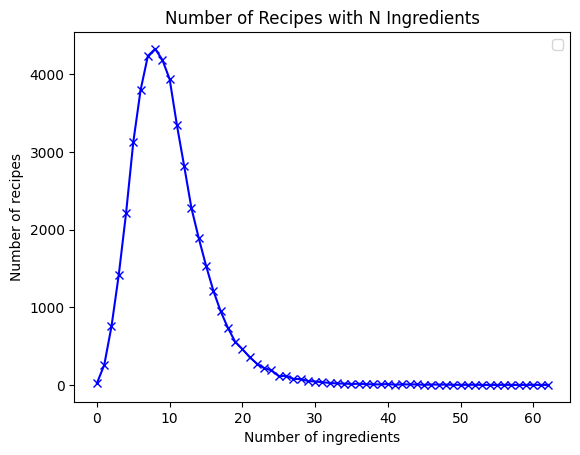

In [15]:
# Plotting the distribution of recipes based on the number of ingredients and calculating median and percentiles.
x = np.arange(0, maxi)
y = np.zeros(x.size)

for ind in x:
    ind_1_ingredient_recipes = np.where(n_ingredient_recipes == ind)[0]
    y[int(ind)] = ind_1_ingredient_recipes.size

plt.plot(x, y, marker='x', color='b', linestyle='-')


# Making plot prettier 
plt.xlabel("Number of ingredients")
plt.ylabel("Number of recipes")
plt.title("Number of Recipes with N Ingredients")
plt.legend()
plt.show()

In [16]:
# Printing the median, 25th percentile, and 75th percentile of the number of ingredients per recipe.
print("median number of ingredient per recipe: " + str(int(np.median(n_ingredient_recipes,axis=0))))
print("q25 number of ingredient per recipe: " + str(int(np.percentile(n_ingredient_recipes, 25, axis=0))))
print("q75 number of ingredient per recipe: " + str(int(np.percentile(n_ingredient_recipes, 75, axis=0))))

median number of ingredient per recipe: 9
q25 number of ingredient per recipe: 6
q75 number of ingredient per recipe: 12


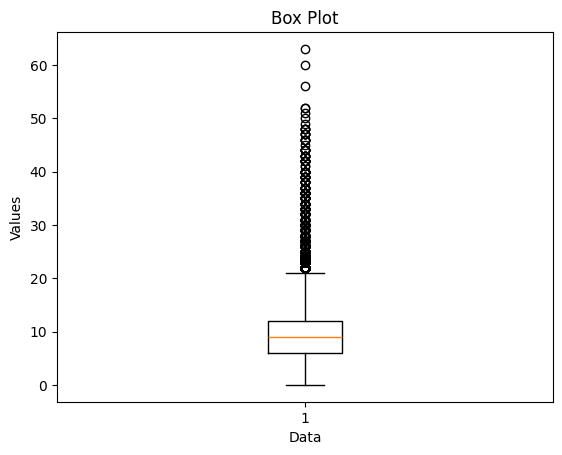

In [17]:
# Creating a box plot to visualize the distribution of the number of ingredients per recipe.

n_ingredient_recipes_dense = np.array(n_ingredient_recipes).flatten()

# Create the boxplot
plt.boxplot(n_ingredient_recipes_dense)
plt.xlabel("Data")
plt.ylabel("Values")
plt.title("Box Plot")
plt.show()


## EDA of Ingredients

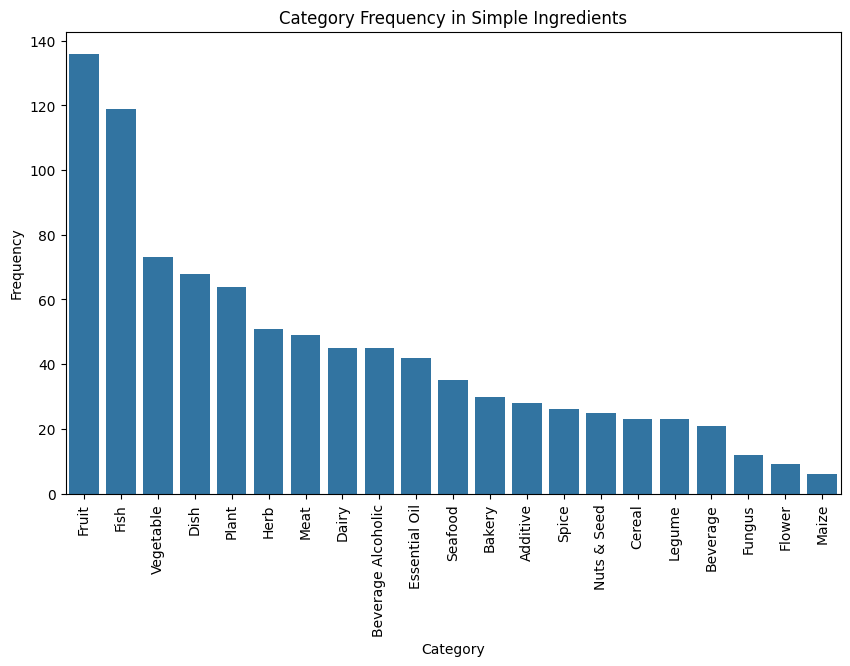

In [18]:
# What's the most popular category of simple ingredients?

df_simple_ingredients = pd.read_csv("../CulinaryDB/02_Ingredients.csv")
category_counts = df_simple_ingredients['Category'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Category Frequency in Simple Ingredients')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


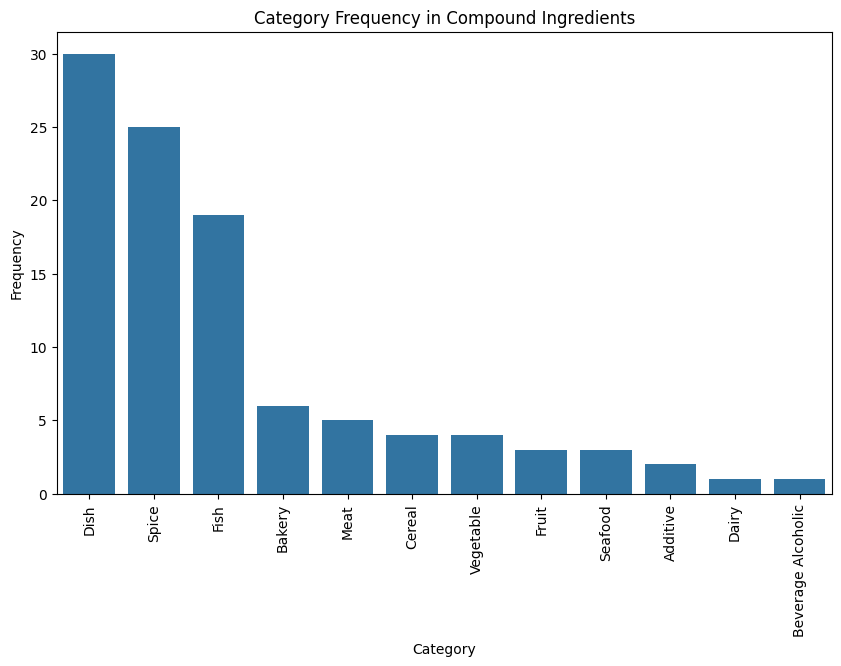

In [19]:
# What's the most popular category of compoung ingredients?

df_compound_ingredients = pd.read_csv("../CulinaryDB/03_Compound_Ingredients.csv")
category_counts = df_compound_ingredients['Category'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Category Frequency in Compound Ingredients')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


In [20]:
df_compound_ingredients[df_compound_ingredients.Category == 'Dish'].head()

,Compound Ingredient Name,Compound Ingredient Synonyms,entity_id,Contituent Ingredients,Category
16,Cake Mix,cake mix,2016,"flour, wheat, sugar, baking powder, salt",Dish
19,Vermicelli,vermicelli,2019,"flour, wheat, water, salt",Dish
21,Mayonnaise,mayonnaise,2021,"oil, egg, lemon-juice",Dish
23,Croissant,croissant,2023,"flour, wheat, butter, yeast",Dish
24,Puff Pastry,puff pastry,2024,"flour, wheat, butter",Dish


#### Hmm a pretty interesting dataset. For isntance, a croissant by itself is a dish but also an ingredient for a recipe haha. Let us see which one as an example:

In [21]:
df_recipe[df_recipe['Entity ID']==2023].head()


,Recipe ID,Original Ingredient Name,Aliased Ingredient Name,Entity ID
34385,4226,"6 croissants, split",croissant,2023
140162,15473,"6 plain croissants, split in half",croissant,2023
147412,16243,"6 croissants, split",croissant,2023
210131,22012,4 croissants,croissant,2023
210663,22065,"Croissants, recipe follows",croissant,2023


In [22]:
df_recipe_name[df_recipe_name['Recipe ID']== 4226]

,Recipe ID,Title,Source,Cuisine
4225,4226,Chicken Chutney Sandwiches with Curry,ALLRECIPES,Indian Subcontinent


#### Ah yes for a sandwich!

#### Now, let us see the minimum and maximum number of recipes that include each ingredient.

In [23]:
# Calculating and printing the minimum and maximum number of recipes that include each ingredient.
n_recipes_per_ingredient = sparse_matrix.sum(axis=0)
print(n_recipes_per_ingredient.shape)
n_recipes_per_ingredient = n_recipes_per_ingredient.T
mini = min(n_recipes_per_ingredient)
maxi = max(n_recipes_per_ingredient)
print("maximum number of recipes per ingredient: " + str(int(maxi[0])))
print("minimum number of recipes per ingredient: " + str(int(mini[0])))

(1, 695)
maximum number of recipes per ingredient: 21185
minimum number of recipes per ingredient: 0


#### Hmm it seems that there are some ingredients that do not appear in any recipes at all...

median number of recipes per ingredient: 65
q25 number of recipes per ingredient: 6
q75 number of recipes per ingredient: 347


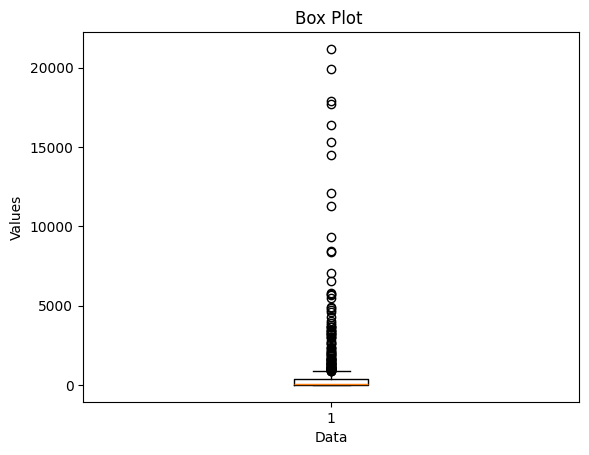

In [24]:
# Computing summary statistics (median, Q25, Q75) and visualizing the distribution of recipes per ingredient using a box plot.

n_recipes_per_ingredient_dense = np.array(n_recipes_per_ingredient).flatten()

print("median number of recipes per ingredient: " + str(int(np.median(n_recipes_per_ingredient_dense))))
print("q25 number of recipes per ingredient: " + str(int(np.percentile(n_recipes_per_ingredient_dense, 25))))
print("q75 number of recipes per ingredient: " + str(int(np.percentile(n_recipes_per_ingredient_dense, 75))))

# Creating the boxplot
plt.boxplot(n_recipes_per_ingredient_dense)
plt.xlabel("Data")
plt.ylabel("Values")
plt.title("Box Plot ")
plt.show()


#### The box plot reveals a highly skewed distribution with numerous outliers, indicating that staple ingredients dominate recipe compositions. This suggests that while many ingredients are niche or specialized, essentials like salt, sugar, and oil are widely used in most recipes.

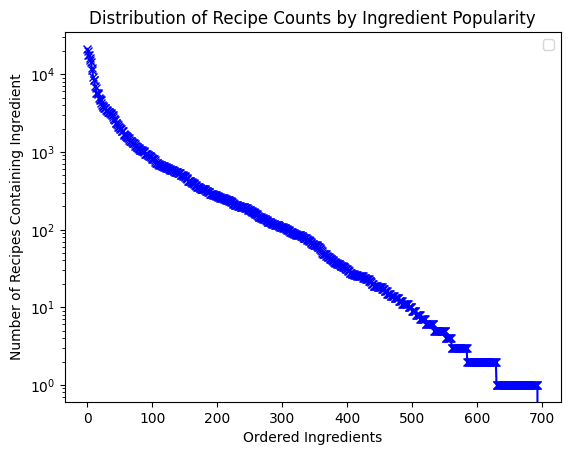

In [25]:
# Plotting the number of recipes per ingredient in descending order on a logarithmic scale.
x = np.arange(0, maxi)
y = np.zeros(x.size)
sorted_n_recipes_per_ingredient = np.flipud(np.sort(n_recipes_per_ingredient,axis=0))
sorted_indices = np.flipud(np.argsort(n_recipes_per_ingredient,axis=0))
plt.plot(np.arange(n_recipes_per_ingredient.size), sorted_n_recipes_per_ingredient, marker='x', color='b', linestyle='-')
plt.xlabel("Ordered Ingredients")
plt.ylabel("Number of Recipes Containing Ingredient")
plt.title("Distribution of Recipe Counts by Ingredient Popularity")
plt.yscale('log')
plt.legend()
plt.show()


#### This further highlights that many ingredients appear in fewer than 10 recipes, while a small number of ingredients are used in the majority of recipes.

#### Let us see what the 20 most popular ingredients are:

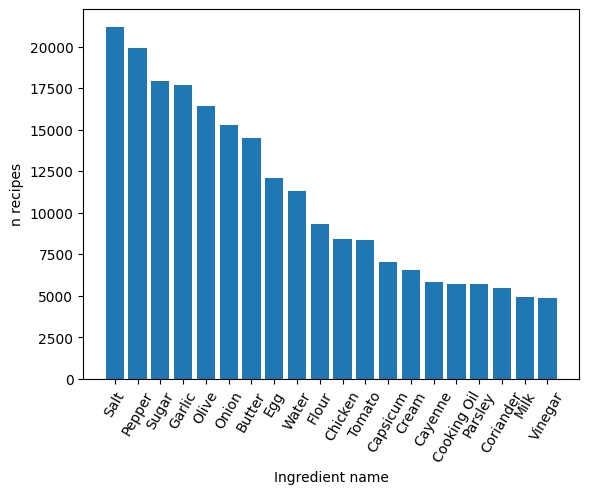

In [26]:
# Finding the top 20 most popular ingredients 
n = 20
indices = sorted_indices[0:n]
x = []
y = []
for count, idx in enumerate(indices, start=1):
    x.append(labels_ingredients_names[idx[0,0]])
    y.append(int(n_recipes_per_ingredient[idx[0,0]].astype(int)))
plt.bar(x, y)
plt.xlabel('Ingredient name')
plt.ylabel('n recipes')
plt.xticks(rotation=60)
plt.show()

#### This ranking makes sense because these ingredients, like salt, pepper, and water, are essential staples and form the foundation of most recipes.

## EDA of Cuisines 

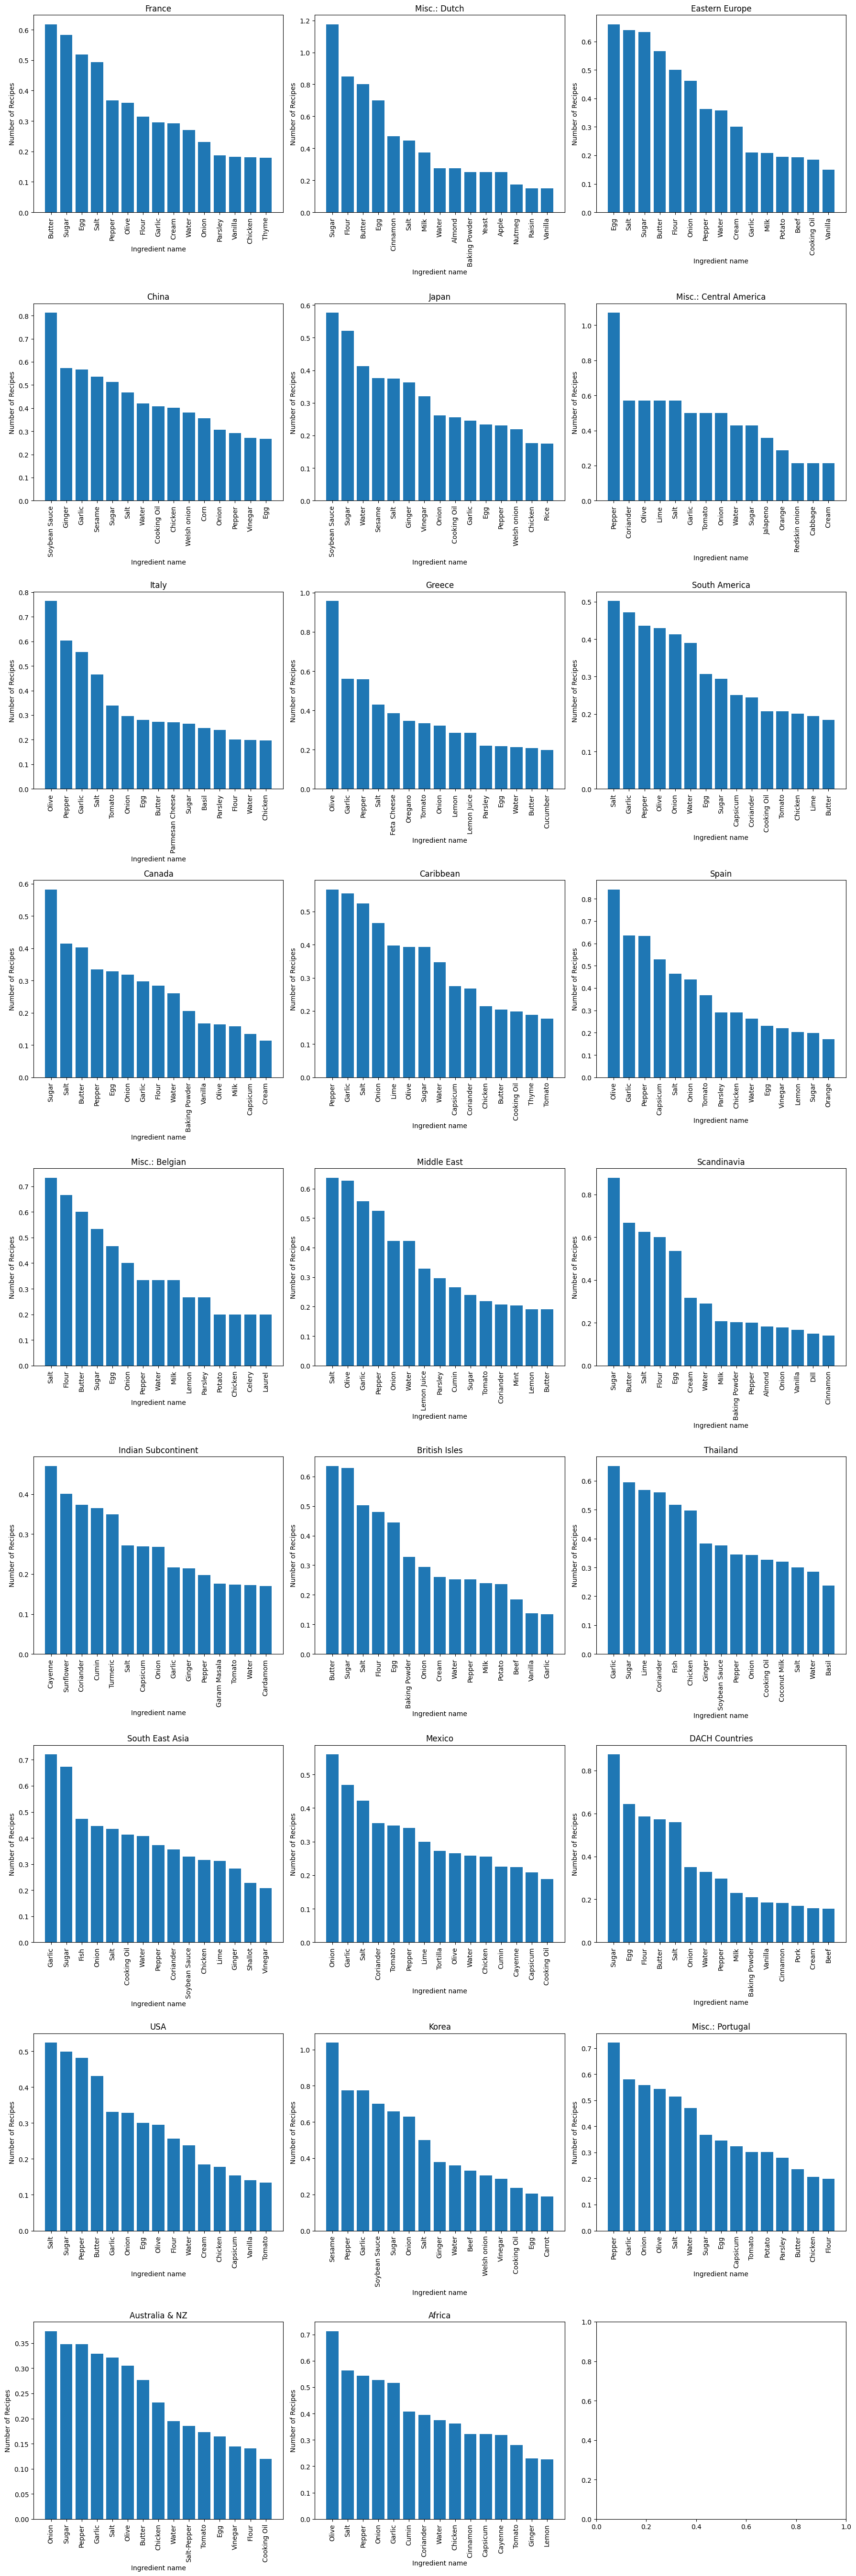

In [28]:
# Let's see what the top ingredients are of each cuisine in our data

n_cuisine = len(label_unique_cuisines)
frequency_ingredients_per_cuisine = np.zeros([n_cuisine, n_ingredients])
n = 15
mat = sparse_matrix.todense()

# Creating subplots with 3 plots per row
n_cols = 3  
n_rows = int(np.ceil(n_cuisine / n_cols)) 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 6)) 

axes = axes.flatten()

for ind in np.unique(labels_recipes_cuisines):
    # Getting the specific cuisine's data
    cuisine_sparse_matrix = mat[labels_recipes_cuisines == ind, :]
    n_recipes_per_ingredient_cuisine = np.asarray(cuisine_sparse_matrix.sum(axis=0))

    frequency_ingredients_per_cuisine[ind, :] = n_recipes_per_ingredient_cuisine / sum(labels_recipes_cuisines == ind)

    sorted_n_recipes_per_ingredient = np.fliplr(np.sort(n_recipes_per_ingredient_cuisine, axis=1))
    sorted_indices = np.fliplr(np.argsort(n_recipes_per_ingredient_cuisine, axis=1))
    indices = np.asarray(sorted_indices[:, 0:n].T)

    x = []
    y = []
    for count, idx in enumerate(indices, start=1):
        x.append(labels_ingredients_names[idx[0]])
        y.append(int(n_recipes_per_ingredient_cuisine[0, idx[0]]))

    # Plotting the bar chart in the selected subplot
    axes[ind].bar(x, y / sum(labels_recipes_cuisines == ind))
    axes[ind].set_xlabel('Ingredient name')
    axes[ind].set_ylabel('Number of Recipes')
    axes[ind].set_title(label_unique_cuisines[ind])
    axes[ind].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


#### Small note: we have 26 cuisines and 3 plots per row, so the last plot isn't an error ha ha 

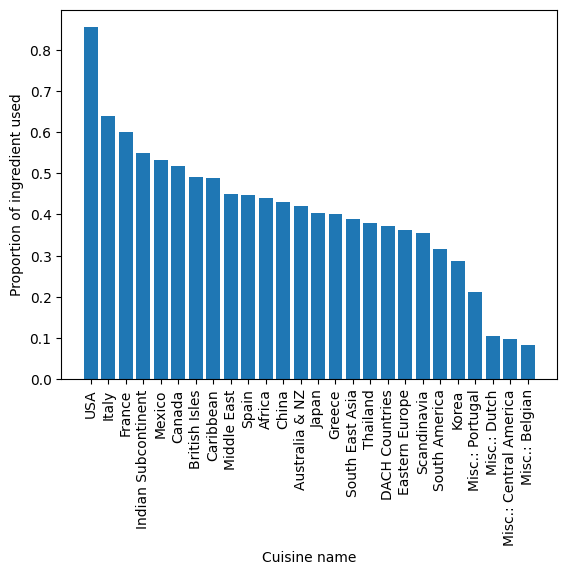

In [29]:
# Calculating the proportion of ingredients used in each cuisine

proportion_ingredient_used_per_cuisine = 1-np.sum(frequency_ingredients_per_cuisine == 0, axis=1)/n_ingredients

# Sorting the cuisines by the proportion of ingredients used in descending order
sorted_indices = np.argsort(proportion_ingredient_used_per_cuisine)[::-1]
sorted_proportion = proportion_ingredient_used_per_cuisine[sorted_indices]
sorted_cuisines = np.array(label_unique_cuisines)[sorted_indices]

# Plotting the sorted data
plt.bar(sorted_cuisines, sorted_proportion)
plt.xlabel('Cuisine name')
plt.ylabel('Proportion of ingredient used')
plt.xticks(rotation=90)
plt.show()


In [30]:
print("median proportion of total number of ingredient used in each cuisine is " + str(int(100*np.median(proportion_ingredient_used_per_cuisine))) + "%")

median proportion of total number of ingredient used in each cuisine is 41%


#### From this, we observe that the USA uses the most ingredients in the database, followed by Italy and France, while Central America and Belgium use the least. The median proportion of ingredients use is 41% though. 

#### Perhaps the graph below will help explain why:

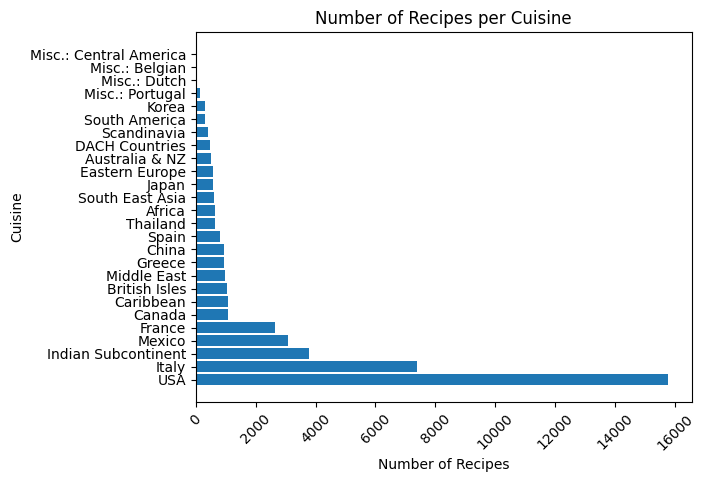

In [31]:
# Let us print what cuisine has the most recipes in this dataset 

# Calculating  the number of recipes for each cuisine
n_recipes_per_cuisine = np.zeros(len(label_unique_cuisines))
for ind in labels_recipes_cuisines:
    n_recipes_per_cuisine[ind] += 1 

# Sorting 
indices = np.flipud(np.argsort(n_recipes_per_cuisine))
labels = np.array(label_unique_cuisines)

# Plotting 
plt.barh(labels[indices], n_recipes_per_cuisine[indices])
plt.xlabel('Number of Recipes')
plt.title('Number of Recipes per Cuisine')
plt.ylabel('Cuisine')
plt.xticks(rotation=45)
plt.show()


#### Now we understand why! The bar chart shows that cuisines like those of the USA, Italy, and France have a large number of recipes in the database, which skews the data. In contrast, cuisines from Central America and Belgium are underrepresented with fewer recipes, resulting in a more limited variety of ingredients.

#### For our future milestones, we are thinking about adding an additional dataset to help balance our data.

## EDA on Recipe Similarity 

### We want to explore how similar recipes are based on their ingredients. For example, clustering recipes, as mentioned in our milestone 1 report, would be useful if we like a recipe but want to try a variation that's not too different. 

In [32]:
# importing the necessary libraries 
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform

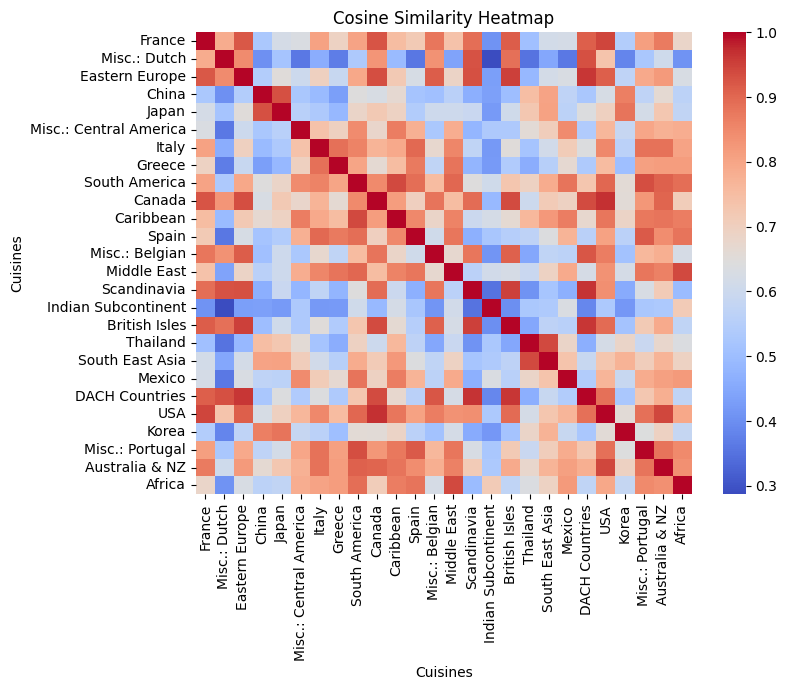

In [33]:
# calculating the cosine similarity between cuisines based on the top 200 most frequent ingredients
# we decided to use cosine similarity because it effectively measures the similarity between cuisines based on their ingredient frequencies

n_ingredient_to_keep = 200

if len(n_recipes_per_ingredient.shape)>1:
    n_recipes_per_ingredient = np.array(n_recipes_per_ingredient)[:,0]
ind_most_frequent_ingredient = np.argsort(n_recipes_per_ingredient)[-n_ingredient_to_keep:][::-1]


#frequency_ingredients_per_cuisine
frequency_top_ing_per_cuisine = frequency_ingredients_per_cuisine[:,ind_most_frequent_ingredient]

similarity_matrix = cosine_similarity(frequency_top_ing_per_cuisine)

# plotting
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, cmap="coolwarm", xticklabels=labels, yticklabels=labels, cbar=True)
plt.title("Cosine Similarity Heatmap")
plt.xlabel("Cuisines")
plt.ylabel("Cuisines")
plt.show()

#### Hmm maybe similarity would be easier to visualize through TSNE in a 2D plot

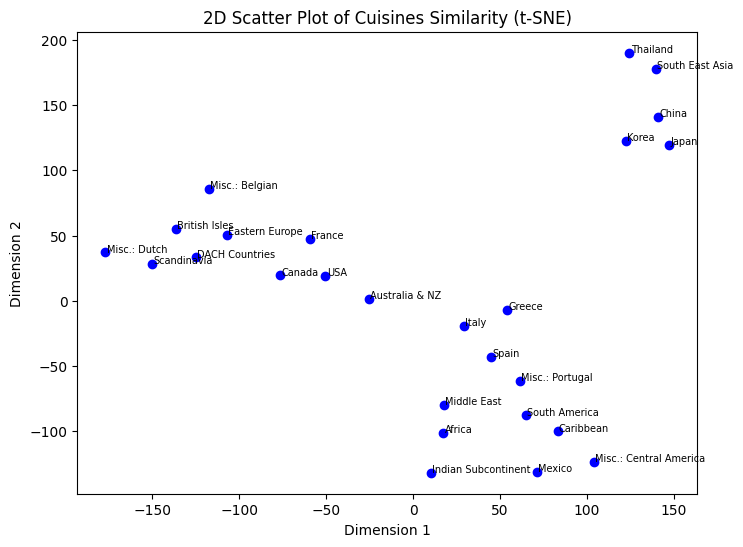

In [34]:
# Using t-SNE for dimensionality reduction on the cosine distance matrix to visualize the similarity between cuisines in a 2D scatter plot.
tsne = TSNE(n_components=2, random_state=42, metric="precomputed", perplexity=5, init="random")  # Using precomputed similarity matrix
cosine_dist = np.clip(1 - similarity_matrix, 0, None) 
tsne_results = tsne.fit_transform(cosine_dist)  # Convert similarity to distance (1 - similarity)

# plotting 
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c='blue', marker='o')
for i, label in enumerate(labels):
    plt.text(tsne_results[i, 0] + 0.7, tsne_results[i, 1] + 0.2, label, fontsize=7)
plt.title("2D Scatter Plot of Cuisines Similarity (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

### The similarities make sense! 

#### For example, the flavor profiles of Eastern Europe, Scandinavia, and Belgium are quite similar. Cuisines from geographically close regions tend to cluster together due to shared ingredients and culinary traditions, as also seen with East Asian or European cuisines. 

#### Cultural and historical exchanges also influence ingredient usage, like in the Caribbean and South America. The availability of regional ingredients, such as in Southeast Asia, drives further clustering, while shared cooking techniques, like the use of spices in Indian and Middle Eastern cuisines, contribute to their proximity on the plot.

## EDA for Ingredient Proximity 

### Similar to recipe proximity, we aim to explore which ingredients are frequently paired together in recipes.

In [35]:
# importing necessary librairies 
from itertools import combinations
import plotly.express as px
import plotly.graph_objects as go
import scipy.cluster.hierarchy as sch

In [36]:
# Calculating the co-occurrence matrix for the most frequent ingredients, determining how often ingredient pairs appear together in the same recipes

# Creating a smaller sparse matrix with only the most frequent ingredients
sparse_matrix_small = sparse_matrix[:, ind_most_frequent_ingredient]

cooccurrence_matrix = np.zeros([len(ind_most_frequent_ingredient), len(ind_most_frequent_ingredient)])

# Looping through each recipe to calculate ingredient co-occurrence
for ind in range(sparse_matrix_small.shape[0]):
    temp_recipe = sparse_matrix_small[ind, :]
    ind_coocur = temp_recipe.nonzero()[1]
    if ind_coocur.size > 0:
        if ind_coocur.size > 1:
            pairs_coocur = list(combinations(ind_coocur, 2))
            rows, cols = zip(*pairs_coocur)
            cooccurrence_matrix[rows, cols] += 1
            cooccurrence_matrix[cols, rows] += 1


# Normalizing the co-occurrence matrix by the number of recipes containing each ingredient
cooccurrence_matrix = cooccurrence_matrix / n_recipes_per_ingredient[ind_most_frequent_ingredient]

# Ensuring the matrix is symmetric (since co-occurrence is bidirectional)
cooccurrence_matrix = np.minimum(cooccurrence_matrix, cooccurrence_matrix.T)

cooccurrence_matrix[np.arange(cooccurrence_matrix.shape[1]), np.arange(cooccurrence_matrix.shape[1])] = 1

# Visualizing the result
fig = px.imshow(cooccurrence_matrix, 
                labels=dict(x="Ingredients", y="Ingredients", color="Similarity"), 
                x=np.array(labels_ingredients_names)[ind_most_frequent_ingredient],  # Labels for x-axis
                y=np.array(labels_ingredients_names)[ind_most_frequent_ingredient],  # Labels for y-axis
                color_continuous_scale='Viridis', 
                title="Ingredient cooccurrence matrix")
fig.show()


#### Note: since these plots are interactive, they are not visible on our github repository without running the whole notebook. For this reason, we have included screenshots of our plot below. On the top, we see the whole concurrence matrix. On the bottom image, we see an example zoom in onto a point in the matrix. 

<p align="center"> 
<img src="images/example1.png" width="600">
</p>

#### Let us now try making a 2D plot representation of these pairings...

In [37]:
# Using t-SNE in a similar manner
tsne = TSNE(n_components=2, random_state=42, metric="precomputed", perplexity=3, init="random")  
dist_mat = np.clip(1 - cooccurrence_matrix, 0, None) 
tsne_results = tsne.fit_transform(dist_mat ** 3) 
x = tsne_results[:, 0]
y = tsne_results[:, 1]

df = pd.DataFrame({
    'x': x,
    'y': y,
    'labels': np.array(labels_ingredients_names)[ind_most_frequent_ingredient]
})
fig = go.Figure(data=go.Scatter(
    x=df['x'], 
    y=df['y'],
    mode='markers+text',  
    text=df['labels'], 
    textposition='top center', 
))
fig.update_layout(
    autosize=True, 
    title_x=0.5,
    showlegend=False, 
    xaxis=dict(showgrid=False), 
    yaxis=dict(showgrid=False)  
)

# Showing the plot
fig.show()

#### Note: Similarly, since these plots are interactive, they are not visible on our github repository without running the whole notebook. On the top, we see the whole plot. On the bottom image, we see an example zoom in onto a point in the plot. 

<p align="center"> 
<img src="images/example2.png" width="600">
</p>


#### Hmm while this provides some useful information, it’s not entirely clear. For example, it makes sense that peanut oil, peanuts, and peanut butter are close to each other. However, in general, not everything in this 2D plot seems logical. It’s not as informative or useful as the 2D t-SNE plot for cuisines. However, it is still a good try. 